In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt


In [0]:
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data (2).csv


1. Prepare the data to form a matrix. Indicate how you dealt with NaN values.

 Answer: For numerical data types, replace NaN values with zero, while for object data types such as string replace NaN with 'None'. For boolean data replace NaN with false.

 Do label encoding for the ordinal data

In [103]:
data = pd.read_csv("train_data.csv")

# Remove Id Column
data = data.drop([data.columns[0]], axis=1)

# Remove NaN from empty cells
# Label Encode categorical data
for column in data:
    if data.loc[:, column].dtype == 'int64' or data.loc[:, column].dtype == 'float64':
        data.loc[:, column].fillna(0, inplace=True)
    elif data.loc[:, column].dtype == 'object':
        data.loc[:, column].fillna('None', inplace=True)
        data.loc[:, column] = data.loc[:, column].astype('category')
        data.loc[:, column] = data.loc[:, column].cat.codes
    elif data.loc[:, column].dtype == 'bool':
        data.loc[:, column].fillna(False, inplace=True)

# Nominal Encoding
nominal = ['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
           'Neighborhood', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl',
           'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
           'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 
           'MiscFeature', 'SaleType', 'SaleCondition']


for feature in nominal:
  dummy_df = pd.get_dummies(data[feature], prefix=feature)
  data = pd.concat([data, dummy_df], axis=1)
  data.drop(feature, axis=1, inplace=True)

data.head(20)


,MSSubClass,LotFrontage,LotArea,LotShape,Utilities,LandSlope,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Heating_4,Heating_5,CentralAir_0,CentralAir_1,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,Electrical_5,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,PavedDrive_0,PavedDrive_1,PavedDrive_2,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,60,65.0,8450,3,0,0,0,5,7,5,2003,2003,196.0,2,4,2,4,3,2,706,6,0,150,856,0,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,3,0,0,0,2,6,8,1976,1976,0.0,3,4,2,4,1,0,978,6,0,284,1262,0,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,0,0,0,0,5,7,5,2001,2002,162.0,2,4,2,4,2,2,486,6,0,434,920,0,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,0,0,0,0,5,7,5,1915,1970,0.0,3,4,4,1,3,0,216,6,0,540,756,2,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,0,0,0,0,5,8,5,2000,2000,350.0,2,4,2,4,0,2,655,6,0,490,1145,0,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,50,85.0,14115,0,0,0,0,0,5,5,1993,1995,0.0,3,4,2,4,3,2,732,6,0,64,796,0,796,566,0,1362,1,0,1,1,1,1,3,5,6,0,3,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
6,20,75.0,10084,3,0,0,0,2,8,5,2004,2005,186.0,2,4,0,4,0,2,1369,6,0,317,1686,0,1694,0,0,1694,1,0,2,0,3,1,2,7,6,1,2,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
7,60,0.0,10382,0,0,0,0,5,7,6,1973,1973,240.0,3,4,2,4,2,0,859,1,32,216,1107,0,1107,983,0,2090,1,0,2,1,3,1,3,7,6,2,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
8,50,51.0,6120,3,0,0,0,0,7,5,1931,1950,0.0,3,4,4,4,3,6,0,6,0,952,952,2,1022,752,0,1774,0,0,2,0,2,2,3,8,2,2,5,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
9,190,50.0,7420,3,0,0,1,1,5,6,1939,1950,0.0,3,4,4,4,3,2,851,6,0,140,991,0,1077,0,0,1077,1,0,1,0,2,2,3,5,6,2,5,...,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


2. Perform PCA and filter out 2 Principal Components

 Answer: Data encoding was done in previous step. The features are all columns except the last one which is the target.

 First scale the feature data using sklearn's StandardScaler.

In [0]:
x = data.drop(['SalePrice'], axis=1).values
y = data[['SalePrice']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)


Use sklearn's PCA class for Principle Component Analysis.

In [114]:
pca = PCA(n_components=2)
principle_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principle_components,
                           columns = ['principal component 1', 'principal component 2'])

final_data = pd.concat([principal_df, data[['SalePrice']]], axis=1)
final_data

,principal component 1,principal component 2,SalePrice
0,3.176038,0.534994,208500
1,-0.287635,-2.888179,181500
2,3.517764,0.183602,223500
3,-2.016659,0.755296,140000
4,5.448319,0.063875,250000
...,...,...,...
1455,1.793607,1.209228,175000
1456,1.321911,-4.185400,210000
1457,0.257471,0.907560,266500
1458,-2.878036,-2.877592,142125


3. Determine the percentage of information carried by each of the above 2 Pricipal Components.

In [115]:
variance_ratio = pca.explained_variance_ratio_

print('principal component 1%: ', variance_ratio[0]*100)
print('principal component 2%: ', variance_ratio[1]*100)

principal component 1%:  6.673021714669189
principal component 2%:  3.294818795308737


4. If we were to capture 90% variance, how many PCs will be needed?

In [122]:
variance_threshold = 0.90
pca2 = PCA()
principle_components2 = pca2.fit_transform(x)
cumulative_variance = np.cumsum(pca2.explained_variance_ratio_)
no_of_variables = sum(x <= variance_threshold for x in cumulative_variance)
print("PCs needed: ", no_of_variables)

PCs needed:  121


5. Plot a 3D plane of Best Fit

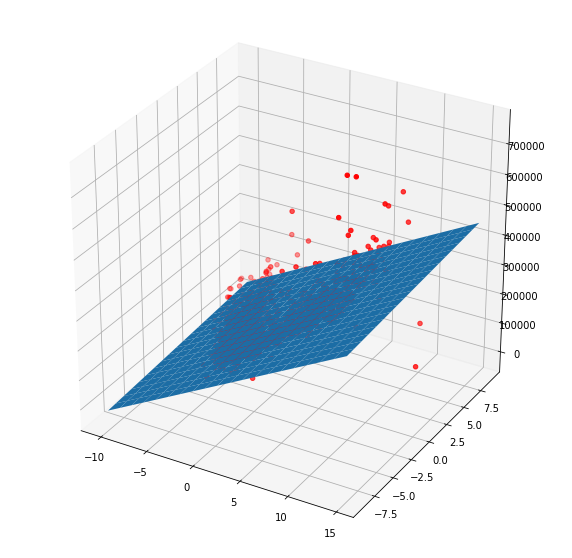

In [117]:
train_x = final_data.iloc[:, :-1]
train_y = final_data.iloc[:,-1]
regressor = LassoCV().fit(train_x, train_y)

min_val = np.min(final_data, axis=0)
max_val = np.max(final_data, axis=0)
plot_x, plot_y = np.meshgrid(np.linspace(min_val[0], max_val[0], 20), np.linspace(min_val[1], max_val[1], 20))

w1 = regressor.coef_[0]
w2 = regressor.coef_[1]
b = regressor.intercept_
z = w1 * plot_x + w2 * plot_y + b

graph = plt.figure().gca(projection='3d')
plt.rcParams['figure.figsize'] = (10, 10)
graph.plot_surface(plot_x, plot_y, z)
graph.scatter(final_data['principal component 1'], final_data['principal component 2'], final_data['SalePrice'], c='r')

6. Write down the general linear regression equation for this challenge using only two PCs.

In [119]:
print("w1: ", w1)
print("w2: ", w2)
print("y-intercept: ", b)

w1:  16757.068796359847
w2:  2461.64546778187
y-intercept:  180921.19589041095


y = 16757.069x1 + 2461.645x2 + 180921.195